In [ ]:
# https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd './MultiLabelProcessing'

/content/drive/My Drive/Misc Practice/MultiLabelProcessing


In [3]:
pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-qqi2plop
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-qqi2plop
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-cp36-none-any.whl size=43005 sha256=054892c2634f756efad6769df36473d90ed3023f648e3b55ccccdf22a4515b57
  Stored in directory: /tmp/pip-ephem-wheel-cache-atgaopnj/wheels/03/a0/39/171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


In [4]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
import pandas as pd

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers import InputLayer, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.preprocessing import image
#from tensorflow.python.keras.applications import VGG16
from keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import Adam, RMSprop

In [5]:
# Read from csv file which puts binary value corresponding to each class for any given image

df=pd.read_csv('./MultiLabelProcessing/miml_dataset/miml_labels_1.csv')

In [26]:
# variable to hold types of classes(or different labels)
columns=["desert", "mountains", "sea", "sunset", "trees"]

#Defining flow_from_dataframe function from ImageDataGenerator to handle the Multi-Label classification

datagen_train=ImageDataGenerator(rescale=1./255.)

datagen_test=ImageDataGenerator(rescale=1./255.)

generator_train=datagen_train.flow_from_dataframe(
dataframe=df[:1800],
directory="./MultiLabelProcessing/miml_dataset/images",
x_col="Filenames",
y_col=columns,
batch_size=32,
shuffle=True,
class_mode="other",
target_size=(224, 224)) #this size can vary as per the requirement

generator_valid=datagen_test.flow_from_dataframe(
dataframe=df[1800:1900],
directory="./MultiLabelProcessing/miml_dataset/images",
x_col="Filenames",
y_col=columns,
batch_size=32,
shuffle=True,
class_mode="other",
target_size=(224, 224))

generator_test=datagen_test.flow_from_dataframe(
dataframe=df[1900:],
directory="./MultiLabelProcessing/miml_dataset/images",
x_col="Filenames",
batch_size=32,
shuffle=False,
class_mode=None,
target_size=(224, 224))

In [7]:
STEP_SIZE_VALID=generator_valid.n//generator_valid.batch_size

STEP_SIZE_TEST=generator_test.n//generator_test.batch_size
STEP_SIZE_TRAIN=generator_train.n//generator_train.batch_size


In [8]:
# We will make use of transfer learning principle

# Pre-Trained Model: VGG16
model = VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 4s 0us/step


In [9]:
# The lower layers of a Convolutional Neural Network can recognize many different shapes or features in an image. 
# It is the last few fully-connected layers that combine these featuers into classification of a whole image. 
# So we can try and re-route the output of the last convolutional layer of the VGG16 model to a new fully-connected neural network 
# that we create for doing classification on our dataset.

# Getting the summary of the VGG-16 model will help to identify the name of the 
# last convolutional layer of this model we would like to choose for our purpose
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
# We can see that the last convolutional layer is called 'block5_pool' so we use Keras to get a reference to that layer.
# We refer to this layer as the Transfer Layer because its output will be re-routed to our new fully-connected neural network
# which will do the classification for our dataset

transfer_layer = model.get_layer('block5_pool')
print(transfer_layer.output)

Tensor("block5_pool/MaxPool:0", shape=(None, 7, 7, 512), dtype=float32)


In [11]:
# Next is to create a new model using Keras API
# First we take the part of the VGG16 model from its input-layer to the output of the transfer-layer
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)                

# Next we will build a new model on top of this
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# convolutional layer.
new_model.add(Flatten())

# Add a dense (i.e fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer to prevent possible overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.For Multilabel Classification we use 'sigmoid' activation
'''
In case of multi-label image classification, we can have more than one label for a single image. 
We want the probabilities to be independent of each other. Using the softmax activation function will not be appropriate. 
Instead, we can use the sigmoid activation function. This will predict the probability for each class independently. 
It will internally create n models (n here is the total number of classes), one for each class and predict the probability for each class.

Using sigmoid activation function will turn the multi-label problem to n number of binary classification problems. 
So for each image, we will get probabilities defining whether the image belongs to class 1 or not, and so on. 
Since we have converted it into a n – binary classification problem, we will use the binary_crossentropy loss. 
Our aim is to minimize this loss in order to improve the performance of the model.

This is the major change we have to make while defining the model architecture for solving a multi-label image classification problem.
'''
new_model.add(Dense(5, activation='sigmoid'))

In [12]:
# Next our new model is required to be compiled to have the changes made on it to take effect
new_model.compile(RMSprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

In [13]:
# Train the model
history = new_model.fit_generator(generator=generator_train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=generator_valid,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
56/56 [==============================] - 3206s 57s/step - loss: 0.5931 - accuracy: 0.2862 - val_loss: 0.4681 - val_accuracy: 0.7604


In [17]:
# Validation of model performance

# Pre-process the test image before using for model performance validation
img = image.load_img('<path of test image>',target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255

desert (0.459)
sunset (0.368)
sea (0.252)


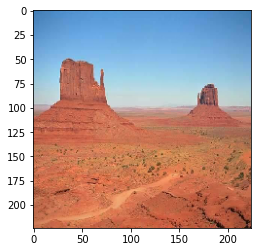

In [26]:
# The model will predict the probability for each class present in test image and we will take the top 3 predictions

classes = np.array(columns)
proba = new_model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)
